In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import pandas as pd

random.seed(42)
np.random.seed(42)
SEED = 42
BATCH_SIZE = 1024

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
def to_categorical(y, num_classes=None, dtype='float32'):
    """
    From keras sorucecode: https://github.com/keras-team/keras/blob/master/keras/utils/np_utils.py#L9
    """

    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [3]:
# import tensorflow as tf
# from keras import backend as K
# from keras.utils import to_categorical

def data_preparation():
    # The column names are from
    # https://www2.1010data.com/documentationcenter/prod/Tutorials/MachineLearningExamples/CensusIncomeDataSet.html
    column_names = ['age', 'class_worker', 'det_ind_code', 'det_occ_code', 'education', 'wage_per_hour', 'hs_college',
                    'marital_stat', 'major_ind_code', 'major_occ_code', 'race', 'hisp_origin', 'sex', 'union_member',
                    'unemp_reason', 'full_or_part_emp', 'capital_gains', 'capital_losses', 'stock_dividends',
                    'tax_filer_stat', 'region_prev_res', 'state_prev_res', 'det_hh_fam_stat', 'det_hh_summ',
                    'instance_weight', 'mig_chg_msa', 'mig_chg_reg', 'mig_move_reg', 'mig_same', 'mig_prev_sunbelt',
                    'num_emp', 'fam_under_18', 'country_father', 'country_mother', 'country_self', 'citizenship',
                    'own_or_self', 'vet_question', 'vet_benefits', 'weeks_worked', 'year', 'income_50k']

    # Load the dataset in Pandas
    train_df = pd.read_csv(
        'data/census-income.data.gz',
        delimiter=',',
        header=None,
        index_col=None,
        names=column_names
    )
    other_df = pd.read_csv(
        'data/census-income.test.gz',
        delimiter=',',
        header=None,
        index_col=None,
        names=column_names
    )

    # First group of tasks according to the paper
    label_columns = ['income_50k', 'marital_stat']

    # One-hot encoding categorical columns
    categorical_columns = ['class_worker', 'det_ind_code', 'det_occ_code', 'education', 'hs_college', 'major_ind_code',
                           'major_occ_code', 'race', 'hisp_origin', 'sex', 'union_member', 'unemp_reason',
                           'full_or_part_emp', 'tax_filer_stat', 'region_prev_res', 'state_prev_res', 'det_hh_fam_stat',
                           'det_hh_summ', 'mig_chg_msa', 'mig_chg_reg', 'mig_move_reg', 'mig_same', 'mig_prev_sunbelt',
                           'fam_under_18', 'country_father', 'country_mother', 'country_self', 'citizenship',
                           'vet_question']
    train_raw_labels = train_df[label_columns]
    other_raw_labels = other_df[label_columns]
    transformed_train = pd.get_dummies(train_df.drop(label_columns, axis=1), columns=categorical_columns)
    transformed_other = pd.get_dummies(other_df.drop(label_columns, axis=1), columns=categorical_columns)

    # Filling the missing column in the other set
    transformed_other['det_hh_fam_stat_ Grandchild <18 ever marr not in subfamily'] = 0

    # One-hot encoding categorical labels
    train_income = to_categorical((train_raw_labels.income_50k == ' 50000+.').astype(int), num_classes=2)
    train_marital = to_categorical((train_raw_labels.marital_stat == ' Never married').astype(int), num_classes=2)
    other_income = to_categorical((other_raw_labels.income_50k == ' 50000+.').astype(int), num_classes=2)
    other_marital = to_categorical((other_raw_labels.marital_stat == ' Never married').astype(int), num_classes=2)

    dict_outputs = {
        'income': train_income.shape[1],
        'marital': train_marital.shape[1]
    }
    dict_train_labels = {
        'income': train_income,
        'marital': train_marital
    }
    dict_other_labels = {
        'income': other_income,
        'marital': other_marital
    }
    output_info = [(dict_outputs[key], key) for key in sorted(dict_outputs.keys())]

    # Split the other dataset into 1:1 validation to test according to the paper
    validation_indices = transformed_other.sample(frac=0.5, replace=False, random_state=SEED).index
    test_indices = list(set(transformed_other.index) - set(validation_indices))
    validation_data = transformed_other.iloc[validation_indices]
    validation_label = [dict_other_labels[key][validation_indices] for key in sorted(dict_other_labels.keys())]
    test_data = transformed_other.iloc[test_indices]
    test_label = [dict_other_labels[key][test_indices] for key in sorted(dict_other_labels.keys())]
    train_data = transformed_train
    train_label = [dict_train_labels[key] for key in sorted(dict_train_labels.keys())]

    return train_data, train_label, validation_data, validation_label, test_data, test_label, output_info

train_data, train_label, validation_data, validation_label, test_data, test_label, output_info = data_preparation()

In [4]:
def getTensorDataset(my_x, my_y):
    tensor_x = torch.Tensor(my_x)
    tensor_y = torch.Tensor(my_y)
    return torch.utils.data.TensorDataset(tensor_x, tensor_y)

train_label_tmp = np.column_stack((np.argmax(train_label[0], axis=1), np.argmax(train_label[1], axis=1)))
train_loader = DataLoader(dataset=getTensorDataset(train_data.to_numpy(), train_label_tmp), batch_size=BATCH_SIZE)

validation_label_tmp = np.column_stack((np.argmax(validation_label[0], axis=1), np.argmax(validation_label[1], axis=1)))
val_loader = DataLoader(dataset=getTensorDataset(validation_data.to_numpy(), validation_label_tmp), batch_size=BATCH_SIZE)

### Define the model

In [5]:
class Expert(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        # self.log_soft = nn.LogSoftmax(1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        # out = self.log_soft(out)
        return out
    
class Tower(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Tower, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        # self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        # out = self.softmax(out)
        out = self.sigmoid(out)
        return out

In [6]:
class MMOE(torch.nn.Module):
    def __init__(self, input_size, num_experts, experts_out, experts_hidden, towers_hidden, tasks):
        super(MMOE, self).__init__()
        # params
        self.input_size = input_size
        self.num_experts = num_experts
        self.experts_out = experts_out
        self.experts_hidden = experts_hidden
        self.towers_hidden = towers_hidden
        self.tasks = tasks
        # row by row
        self.softmax = nn.Softmax(dim=1)
        # model
        self.experts = nn.ModuleList([Expert(self.input_size, self.experts_out, self.experts_hidden) for i in range(self.num_experts)])
        self.w_gates = nn.ParameterList([nn.Parameter(torch.randn(input_size, num_experts), requires_grad=True) for i in range(self.tasks)])
        self.towers = nn.ModuleList([Tower(self.experts_out, 1, self.towers_hidden) for i in range(self.tasks)])

    def forward(self, x):
        # get the experts output
        expers_o = [e(x) for e in self.experts]
        expers_o_tensor = torch.stack(expers_o)
        
        # get the gates output
        gates_o = [self.softmax(x @ g) for g in self.w_gates]
        
        # multiply the output of the experts with the corresponding gates output
        # res = gates_o[0].t().unsqueeze(2).expand(-1, -1, self.experts_out) * expers_o_tensor
        # https://discuss.pytorch.org/t/element-wise-multiplication-of-the-last-dimension/79534
        towers_input = [g.t().unsqueeze(2).expand(-1, -1, self.experts_out) * expers_o_tensor for g in gates_o]
        towers_input = [torch.sum(ti, dim=0) for ti in towers_input]
        
        # get the final output from the towers
        final_output = [t(ti) for t, ti in zip(self.towers, towers_input)]
        
        # get the output of the towers, and stack them
        # final_output = torch.stack(final_output, dim=1)
        
        return final_output

In [7]:
simple_input = torch.tensor([[10.0, 10.0, 15.0, 30.0, 18.0], [20.0, 50.0, 28.0, 22.0, 12.0], [20.0, 50.0, 28.0, 22.0, 12.0]])
mmoe = MMOE(input_size=5, num_experts=3, experts_out=4, experts_hidden=2, towers_hidden=2, tasks=2)

In [8]:
mmoe(simple_input)

[tensor([[0.2640],
         [0.5260],
         [0.5105]], grad_fn=<SigmoidBackward>),
 tensor([[0.3809],
         [0.3776],
         [0.3809]], grad_fn=<SigmoidBackward>)]

In [9]:
model = MMOE(input_size=499, num_experts=6, experts_out=16, experts_hidden=32, towers_hidden=8, tasks=2)
model = model.to(device)
# print(model.state_dict())

### Define the training part

In [10]:
# Sets hyper-parameters
lr = 1e-4
n_epochs = 100

# Defines loss function and optimizer
# loss_fn = nn.CrossEntropyLoss(reduction='mean')
loss_fn = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    # Uses loader to fetch one mini-batch for training
    epoch_loss = []
    c = 0
    print("Epoch: {}/{}".format(epoch, n_epochs))
    for x_batch, y_batch in train_loader:
        # NOW, sends the mini-batch data to the device
        # so it matches location of the MODEL
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # One stpe of training
        yhat = model(x_batch)
        
        # loss = loss_fn(yhat, y_batch)
        
        y_batch_t1, y_batch_t2 = y_batch[:, 0], y_batch[:, 1]
        yhat_t1, yhat_t2 = yhat[0], yhat[1]
        
        loss_t1 = loss_fn(yhat_t1, y_batch_t1.view(-1, 1))
        loss_t2 = loss_fn(yhat_t2, y_batch_t2.view(-1, 1))
        loss = loss_t1 + loss_t2
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss.append(loss.item())
        if c % 50 == 0:
            print("    Batch: {}/{}".format(c, int(len(train_data)/BATCH_SIZE)))
        c += 1
    losses.append(np.mean(epoch_loss))
        
    # After finishing training steps for all mini-batches,
    # it is time for evaluation!
        
    # We tell PyTorch to NOT use autograd...
    with torch.no_grad():
        # Uses loader to fetch one mini-batch for validation
        epoch_loss = []
        for x_val, y_val in val_loader:
            # Again, sends data to same device as model
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()
            # Makes predictions
            yhat = model(x_val)
            # Computes validation loss
            # val_loss = loss_fn(yhat, y_val)
            
            y_val_t1, y_val_t2 = y_val[:, 0], y_val[:, 1]
            yhat_t1, yhat_t2 = yhat[0], yhat[1]

            loss_t1 = loss_fn(yhat_t1, y_val_t1.view(-1, 1))
            loss_t2 = loss_fn(yhat_t2, y_val_t2.view(-1, 1))
            loss = loss_t1 + loss_t2
            
            epoch_loss.append(loss.item())
    val_losses.append(np.mean(epoch_loss))

# print(model.state_dict())
print(np.mean(losses))
print(np.mean(val_losses))

Epoch: 0/100
    Batch: 0/194
    Batch: 50/194
    Batch: 100/194
    Batch: 150/194
Epoch: 1/100
    Batch: 0/194
    Batch: 50/194
    Batch: 100/194
    Batch: 150/194
Epoch: 2/100
    Batch: 0/194
    Batch: 50/194
    Batch: 100/194
    Batch: 150/194
Epoch: 3/100
    Batch: 0/194
    Batch: 50/194
    Batch: 100/194
    Batch: 150/194
Epoch: 4/100
    Batch: 0/194
    Batch: 50/194
    Batch: 100/194
    Batch: 150/194
Epoch: 5/100
    Batch: 0/194
    Batch: 50/194
    Batch: 100/194
    Batch: 150/194
Epoch: 6/100
    Batch: 0/194
    Batch: 50/194
    Batch: 100/194
    Batch: 150/194
Epoch: 7/100
    Batch: 0/194
    Batch: 50/194
    Batch: 100/194
    Batch: 150/194
Epoch: 8/100
    Batch: 0/194
    Batch: 50/194
    Batch: 100/194
    Batch: 150/194
Epoch: 9/100
    Batch: 0/194
    Batch: 50/194
    Batch: 100/194
    Batch: 150/194
Epoch: 10/100
    Batch: 0/194
    Batch: 50/194
    Batch: 100/194
    Batch: 150/194
Epoch: 11/100
    Batch: 0/194
    Batch: 50/194
    

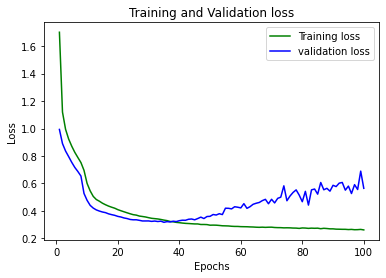

In [11]:
epochs = range(1, n_epochs+1)
plt.plot(epochs, losses, 'g', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing the model

In [12]:
test_label_tmp = np.column_stack((np.argmax(test_label[0], axis=1), np.argmax(test_label[1], axis=1)))
test_loader = DataLoader(dataset=getTensorDataset(test_data.to_numpy(), test_label_tmp), batch_size=BATCH_SIZE)

In [13]:
t1_pred = []
t2_pred = []
t1_target = []
t2_target = []

# We tell PyTorch to NOT use autograd...
with torch.no_grad():
    # Uses loader to fetch one mini-batch for testing
    epoch_loss = []
    for x_test, y_test in test_loader:
        # Again, sends data to same device as model
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        model.eval()
        # Makes predictions
        yhat = model(x_test)

        y_test_t1, y_test_t2 = y_test[:, 0], y_test[:, 1]
        yhat_t1, yhat_t2 = yhat[0], yhat[1]

        loss_t1 = loss_fn(yhat_t1, y_test_t1.view(-1, 1))
        loss_t2 = loss_fn(yhat_t2, y_test_t2.view(-1, 1))
        loss = loss_t1 + loss_t2
        
        # predict
        t1_hat = yhat_t1.view(-1) > 0.5
        t2_hat = yhat_t2.view(-1) > 0.5
        
        # save
        t1_pred.append(t1_hat)
        t2_pred.append(t2_hat)
        t1_target.append(y_test_t1)
        t2_target.append(y_test_t2)
        

        epoch_loss.append(loss.item())
print(np.mean(epoch_loss))

0.5528050381310132


In [14]:
t1_pred = torch.cat(t1_pred)
t2_pred = torch.cat(t2_pred)
t1_target = torch.cat(t1_target)
t2_target = torch.cat(t2_target)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(t1_target.cpu().numpy(), t1_pred.cpu().numpy())

array([[46681,   116],
       [ 2371,   713]])

In [16]:
from sklearn.metrics import classification_report

print(classification_report(t1_target.cpu().numpy(), t1_pred.cpu().numpy()))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     46797
         1.0       0.86      0.23      0.36      3084

    accuracy                           0.95     49881
   macro avg       0.91      0.61      0.67     49881
weighted avg       0.95      0.95      0.94     49881



In [17]:
from sklearn.metrics import classification_report

print(classification_report(t2_target.cpu().numpy(), t2_pred.cpu().numpy()))

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89     28284
         1.0       0.84      0.90      0.87     21597

    accuracy                           0.88     49881
   macro avg       0.88      0.88      0.88     49881
weighted avg       0.88      0.88      0.88     49881



### Testing example for the loss function 

In [18]:
loss = nn.CrossEntropyLoss()
input = torch.tensor([[[0.1, 0.5], [0.1, 0.5]], [[0.1, 0.5], [0.3, 0.5]], [[0.1, 0.5], [1.0, 1.0]]])
target = torch.tensor([[0, 0], [1, 1], [1, 1]])
output = loss(input, target)
output

tensor(0.5821)